# 加载数据模块

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import math

# 步骤 0：定义一个函数来加载训练集和测试集的图像和标签
def load_images_labels(base_path):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    
    # 遍历每个场景的文件夹
    for scene_label in sorted(os.listdir(base_path)):
        scene_path = os.path.join(base_path, scene_label)
        if os.path.isdir(scene_path):
            # 排序确保按文件名序号加载
            image_files = sorted(os.listdir(scene_path))
            # 前150个文件作为训练数据
            for image_file in image_files[:150]:
                image_path = os.path.join(scene_path, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    train_images.append(image)
                    train_labels.append(int(scene_label))
            # 150个以后的文件作为测试数据
            for image_file in image_files[150:]:
                image_path = os.path.join(scene_path, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    test_images.append(image)
                    test_labels.append(int(scene_label))
    
    return train_images, train_labels, test_images, test_labels

# 使用数据集路径加载数据集的图片和label
base_path = './15-Scene' #数据集根目录
train_images, train_labels, test_images, test_labels = load_images_labels(base_path)

# SIFT特征提取模块，涵盖了单个图像的SIFT特征提取函数和能够处理批次图像的SIFT特征提取函数

In [2]:
# 步骤 1：提取 SIFT 特征
def extract_dense_sift_features(image, patch_size=16, step_size=8):
    """
    提取单个图像的SIFT特征
    
    :param image: 输入的单个图像，格式应为灰度。
    :param patch_size: SIFT特征检测的patch大小
    :param step_size: patch间的步长。
    :return: 返回图像的dense SIFT特征。
    """
    # 初始化SIFT检测器
    sift = cv2.SIFT_create()

    # 计算关键点的位置
    keypoints = [cv2.KeyPoint(x, y, patch_size)
                 for y in range(0, image.shape[0], step_size)
                 for x in range(0, image.shape[1], step_size)]
    
    # 计算SIFT特征
    _, descriptors = sift.compute(image, keypoints)
    return descriptors

def extract_all_dense_sift_features(images, patch_size=16, step_size=8):
    all_features = []
    for image in images:
        feature = extract_dense_sift_features(image,patch_size,step_size)
        all_features.append(feature)
    return all_features

if os.path.exists('all_features.npy'):
    pass
else:
    train_descriptors = extract_all_dense_sift_features(train_images)
    test_descriptors = extract_all_dense_sift_features(test_images)
    all_features = []
    for i in range(len(train_descriptors)):
        for j in range(train_descriptors[i].shape[0]):
            all_features.append(train_descriptors[i][j, :])
    np.save('all_features.npy', all_features)#记录展平后的训练集SIFT特征作为视觉词袋

# 超参数搜索（实际放到另一独立脚本运行）、训练K-means构建SPM表示以及将SPM表示用于训练SVM分类器

In [10]:
# 步骤 2：K-means 聚类
def kmeans_clustering(descriptors, k):
    all_descriptors = np.vstack([d for d in descriptors if d is not None])
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(all_descriptors)
    return kmeans

# 步骤 3：构建图像的SPM表示
def SPM(level, imgs, kmeans, k, patch_size,step_size):
    """
    构建图像的SPM表示
    
    :param level: 划分图像的级别
    :param imgs: 输入的图像集合
    :param kmeans: 训练好的Kmeans分类器
    :param k: kmeans聚类数
    :param patch_size: SIFT特征检测的patch大小
    :param step_size: patch间的步长。
    :return: 返回图像的SPM表示。
    """
    result = []  # 存储最终的空间金字塔匹配特征向量
    for i in range(len(imgs)):
        img = imgs[i]  
        H, W = img.shape[0], img.shape[1]  
        single_spm = []  # 存储当前图像的空间金字塔匹配特征向量
        for l in range(level + 1):
            x, y = 0, 0
            step_w = math.floor(W / (2 ** l))  #计算当前层级的网格宽度
            step_h = math.floor(H / (2 ** l))  #计算当前层级的网格高度
            # 对当前层级的每个网格进行处理
            for i in range(1, 2 ** l + 1):
                x = 0
                for j in range(1, 2 ** l + 1):
                    # 提取当前子图像的SIFT特征
                    feature = extract_dense_sift_features(img[y:y + step_h, x:x + step_w],patch_size, step_size)
                    # 使用训练好的KMeans模型对SIFT特征进行分类
                    kmeans_predict = kmeans.predict(feature)
                    # 统计每个视觉词的频率，并构建特征向量
                    histogram = np.bincount(kmeans_predict, minlength=k)
                    histogram = histogram.reshape(1, -1).ravel()
                    # 计算当前层级的权重
                    level_weight = 2 ** (l - level)
                    single_spm.append(level_weight * histogram)
                    x += step_w
                y += step_h
        # 正则化当前图像的特征向量
        single_spm = np.array(single_spm).ravel()
        single_spm = (single_spm - np.mean(single_spm)) / np.std(single_spm)
        result.append(single_spm)
    return np.array(result)

# 步骤 4：训练支持向量机分类器
def train_svm_classifier(features, labels, C=1.0, kernel='linear', gamma='scale'):
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    svm = SVC(C=C, kernel=kernel, gamma=gamma)
    svm.fit(features, labels)
    return svm, scaler

# 测试不同超参数设置
def test_hyperparameters(train_data, train_labels, test_data, test_labels):
    all_features = np.load('all_features.npy')
    # 定义一个参数网格
    param_grid = {
    'k': [200, 400, 600,800,1000],  # K-means 聚类的K值
    'C': [0.1, 1, 10],     # SVM的惩罚参数
    'kernel': ['linear', 'rbf'],  # SVM的核
    'level':[1,2] #图像划分的层数
    }
    
    # 使用ParameterGrid来遍历所有的参数组合
    grid = ParameterGrid(param_grid)
    
    best_score = 0
    best_params = None
    
    for params in grid:
        # 使用当前的参数设置进行训练和评估
        kmeans = kmeans_clustering(all_features, params['k'])
        train_histograms = SPM(params['level'],train_data,kmeans,params['k'],16,8)
        # 在主函数中更新SVM分类器的调用
        svm_classifier, scaler = train_svm_classifier(train_histograms, train_labels, C=params['C'], kernel=params['kernel'])
        test_histograms = SPM(params['level'],test_data,kmeans,params['k'],16,8)
        #test_histograms = build_histograms(test_data,kmeans,params['k'])
        scaled_test_histograms = scaler.transform(test_histograms)
        predictions = svm_classifier.predict(scaled_test_histograms)
        score = np.mean(predictions == test_labels)
        print(f"current params :k-{params['k']},c-{params['C']},kernel-{params['kernel']},level-{params['level']}",f"current score{score}")
        # 如果当前设置的分数是最好的，保存下来
        if score > best_score:
            best_score = score
            best_params = params
            
    print("Best Score: ", best_score)
    print("Best Parameters: ", best_params)
    return best_params

# 测试不同超参数设置，不用的话需要注释掉以节省超参数搜索的时间
#best_params = test_hyperparameters(train_images, train_labels, test_images, test_labels)
#最优超参数组合
best_params = {
    'k': 400,  # K-means 聚类的K值
    'C': 10,     # SVM的惩罚参数
    'kernel': 'linear',  # SVM的核
    'level':2
    }
# 使用最佳参数重新训练分类器
all_features = np.load('all_features.npy')
best_kmeans = kmeans_clustering(all_features, best_params['k'])
best_train_histograms = SPM(best_params['level'],train_images,best_kmeans,best_params['k'],16,8)
best_svm_classifier, best_scaler = train_svm_classifier(best_train_histograms, train_labels, C=best_params['C'], kernel=best_params['kernel'])

# 评估并可视化
scaled_best_test_histograms = best_scaler.transform(SPM(best_params['level'],test_images, best_kmeans, best_params['k'],16,8))
best_predictions = best_svm_classifier.predict(scaled_best_test_histograms)
print(classification_report(test_labels, best_predictions))

              precision    recall  f1-score   support

           0       0.42      0.54      0.47        67
           1       0.89      0.91      0.90        91
           2       0.60      0.45      0.52       161
           3       0.48      0.53      0.50        60
           4       0.61      0.60      0.61       139
           5       0.73      0.80      0.77       210
           6       0.82      0.88      0.85       178
           7       0.81      0.72      0.76       110
           8       0.76      0.66      0.71       158
           9       0.74      0.77      0.75       224
          10       0.72      0.62      0.67       260
          11       0.75      0.86      0.80       142
          12       0.78      0.76      0.77       206
          13       0.72      0.43      0.54        65
          14       0.57      0.75      0.64       165

    accuracy                           0.71      2236
   macro avg       0.69      0.69      0.68      2236
weighted avg       0.71   

# 可视化模块，用于可视化特征向量，以及使用PCA和T-SNE方法将SPM表示对应的特征向量降维可视化

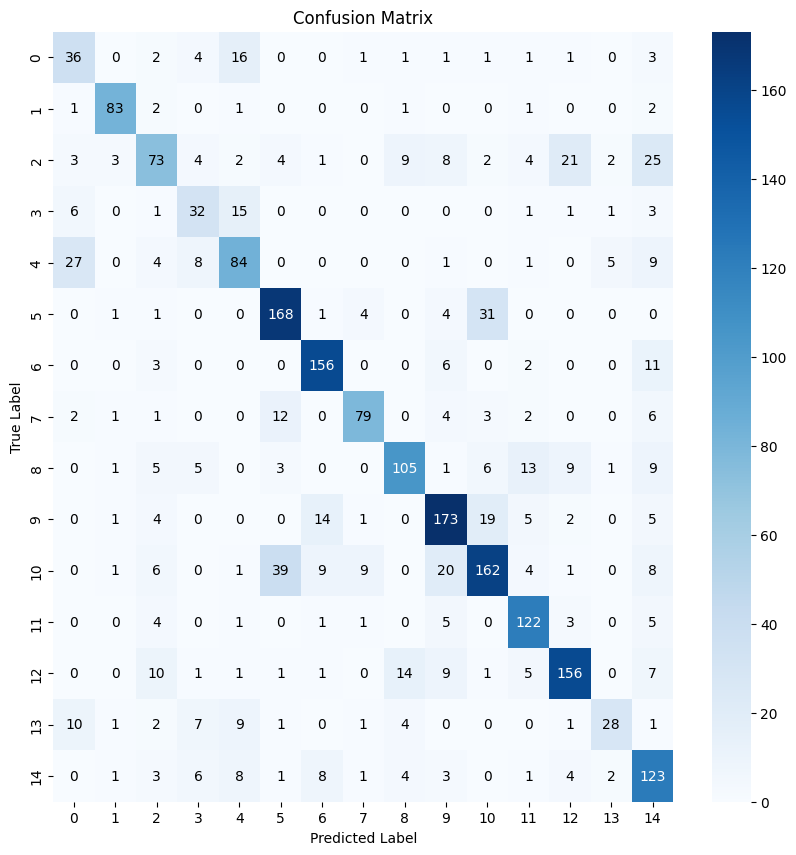

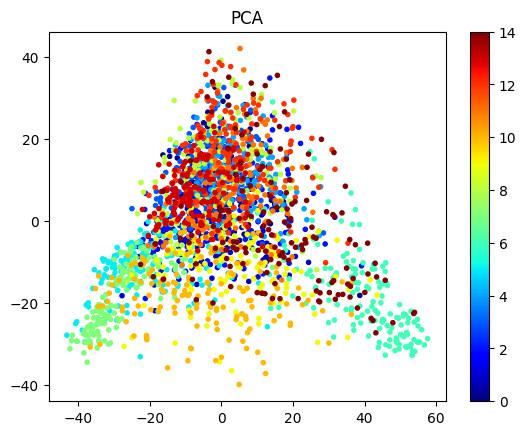

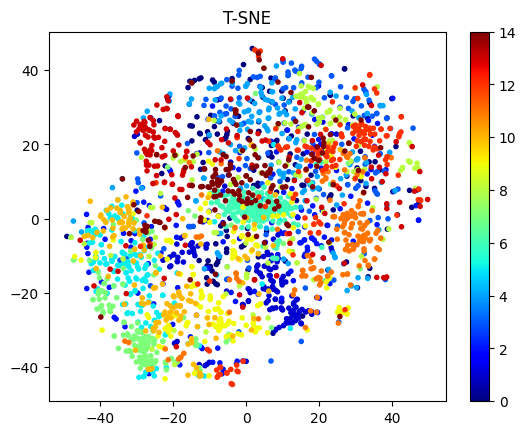

In [12]:
# 可视化 SIFT 特征的聚类效果
def plot_features(features, labels, method='pca'):
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features)
        plt.title('PCA')
    elif method == 'tsne':
        tsne = TSNE(n_components=2, perplexity=30)
        reduced_features = tsne.fit_transform(features)
        plt.title('T-SNE')
    
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='jet', marker='.')
    plt.colorbar()
    plt.show()

# 可视化混淆矩阵
def plot_confusion_matrix(true_labels, pred_labels, classes):
    matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=False, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    # 添加文本注释
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            text_color = "white" if value > matrix.max() / 2 else "black"
            plt.text(j+0.5, i+0.5, value, fontsize=10, ha="center", va="center", color=text_color)

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(test_labels, best_predictions, classes=np.unique(test_labels))

# 可视化特征的聚类效果
all_train_histograms = np.vstack(best_train_histograms)
all_train_labels = np.array(train_labels)
plot_features(all_train_histograms, all_train_labels, method='pca')  # 或 method='tsne'
plot_features(all_train_histograms, all_train_labels, method='tsne')  # 或 method='tsne'